### 一.简介
xgboost分类分两种情况，二分类和多分类：  

（1） 二分类的思路与[logistic回归](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/02_%E7%BA%BF%E6%80%A7%E6%A8%A1%E5%9E%8B_%E9%80%BB%E8%BE%91%E5%9B%9E%E5%BD%92.ipynb)一样，先对线性函数套一个`sigmoid`函数，然后再求交叉熵作为损失函数，所以只需要一组回归树并可实现；   

（2）而多分类的实现，思路同[gbm_classifier](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/10_06_%E9%9B%86%E6%88%90%E5%AD%A6%E4%B9%A0_boosting_gbm_classifier.ipynb)一样，即同时训练多组回归树，每一组代表一个class，然后对其进行`softmax`操作，然后再求交叉熵做为损失函数  

下面对多分类的情况再推一次损失函数、一阶导、二阶导：   

softmax转换：  


$$
softmax(y^{hat})=softmax([y_1^{hat},y_2^{hat},...,y_n^{hat}])=\frac{1}{\sum_{i=1}^n e^{y_i^{hat}}}[e^{y_1^{hat}},e^{y_2^{hat}},...,e^{y_n^{hat}}]
$$   

交叉熵：   

$$
cross\_entropy(y,p)=-\sum_{i=1}^n y_ilog p_i
$$  

将$p_i$替换为$\frac{e^{y_i^{hat}}}{\sum_{i=1}^n e^{y_i^{hat}}}$，得到损失函数如下：   

$$
L(y^{hat},y)=-\sum_{i=1}^n y_ilog \frac{e^{y_i^{hat}}}{\sum_{j=1}^n e^{x_j^{hat}}}\\
=-\sum_{i=1}^n y_i(y_i^{hat}-log\sum_{j=1}^n e^{y_j^{hat}})\\
=log\sum_{i=1}^n e^{y_i^{hat}}-\sum_{i=1}^ny_iy_i^{hat}（由于是onehot展开，所以\sum_{i=1}^n y_i=1）
$$  

所以一阶导：  

$$
\frac{\partial L(y^{hat},y)}{\partial y^{hat}}=softmax([y_1^{hat},y_2^{hat},...,y_n^{hat}])-[y_1,y_2,...,y_n]\\
=softmax(y^{hat})-y
$$    

二阶导：  

$$
\frac{\partial^2 L(y^{hat},y)}{\partial {y^{hat}}^2}=softmax(y^{hat})(1-softmax(y^{hat}))
$$


### 二.代码实现

In [1]:
import os
os.chdir('../')
from ml_models.ensemble import XGBoostBaseTree
from ml_models import utils
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""
xgboost分类树的实现，封装到ml_models.ensemble
"""


class XGBoostClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            self.base_estimator = XGBoostBaseTree()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 扩展class_num组分类器
        self.expand_base_estimators = []

    def fit(self, x, y):
        # 将y转one-hot编码
        class_num = np.amax(y) + 1
        y_cate = np.zeros(shape=(len(y), class_num))
        y_cate[np.arange(len(y)), y] = 1

        # 扩展分类器
        self.expand_base_estimators = [copy.deepcopy(self.base_estimator) for _ in range(class_num)]

        # 第一个模型假设预测为0
        y_pred_score_ = np.zeros(shape=(x.shape[0], class_num))
        # 计算一阶、二阶导数
        g = utils.softmax(y_pred_score_) - y_cate
        h = utils.softmax(y_pred_score_) * (1 - utils.softmax(y_pred_score_))
        # 训练后续模型
        for index in range(0, self.n_estimators):
            y_pred_score = []
            for class_index in range(0, class_num):
                self.expand_base_estimators[class_index][index].fit(x, g[:, class_index], h[:, class_index])
                y_pred_score.append(self.expand_base_estimators[class_index][index].predict(x))
            y_pred_score_ += np.c_[y_pred_score].T * self.learning_rate
            g = utils.softmax(y_pred_score_) - y_cate
            h = utils.softmax(y_pred_score_) * (1 - utils.softmax(y_pred_score_))

    def predict_proba(self, x):
        # TODO:并行优化
        y_pred_score = []
        for class_index in range(0, len(self.expand_base_estimators)):
            estimator_of_index = self.expand_base_estimators[class_index]
            y_pred_score.append(
                np.sum(
                    [estimator_of_index[0].predict(x)] +
                    [self.learning_rate * estimator_of_index[i].predict(x) for i in
                     range(1, self.n_estimators - 1)] +
                    [estimator_of_index[self.n_estimators - 1].predict(x)]
                    , axis=0)
            )
        return utils.softmax(np.c_[y_pred_score].T)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

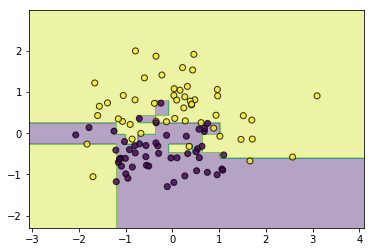

In [3]:
classifier = XGBoostClassifier()
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)